# Introduction

## Environment Setup

In [ ]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from termcolor import colored
import os
from google.colab import drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/RecSys')

songsPath_train = 'train.csv'
df_song_train = pd.read_csv(songsPath_train)
songsPath_test = 'test.csv'
df_song_train = pd.read_csv(songsPath_train)
df_song_test = pd.read_csv(songsPath_test)

Mounted at /content/drive


# Data Understanding

## Data Types
*   media_id - identifiant of the song listened by the user
*   album_id - identifiant of the album of the song
*   media_duration - duration of the song
*   user_gender -  gender of the user
*   user_id -  anonymized id of the user
*   context_type - type of content where the song was listened: playlist, album ...
*   release_date - release date of the song with the format YYYYMMDD
*   ts_listen - timestamp of the listening in UNIX time
*   platform_name - type of os
*   platform_family - type of device
*   user_age - age of the user
*   listen_type - if the songs was listened in a flow or not
*   artist_id - identifiant of the artist of the song
*   genre_id - identifiant of the genre of the song
*   is_listened - 1 if the track was listened, 0 otherwise




## Graphical Analysis



### Distribution of users listening to songs
**Test Data**


any user observed multiple times: False


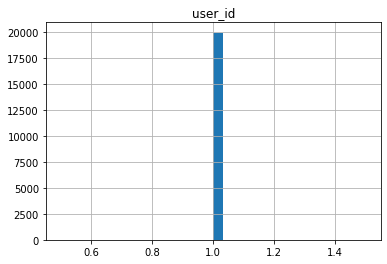

In [ ]:
test_user_id_count = df_song_test.groupby("user_id", as_index=False).agg({"user_id": "count"})

test_user_id_count.hist(bins=30)
anyRedundantUser = (len(test_user_id_count[test_user_id_count["user_id"] > 1]) > 1)
print("any user observed multiple times: {0}".format(anyRedundantUser))


**Train Data**

any user observed multiple times: True


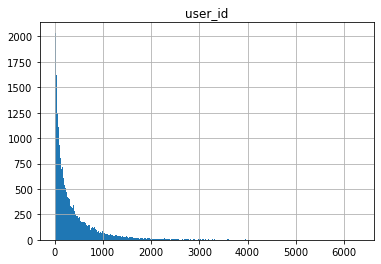

In [ ]:
train_user_id_count = df_song_train.groupby("user_id", as_index=False).agg({"user_id": "count"})
train_user_id_count.hist(bins=300)
anyRedundantUser = (len(train_user_id_count[train_user_id_count["user_id"] > 1]) > 1)
print("any user observed multiple times: {0}".format(anyRedundantUser))

Above histogram shows that the observations per user is different from the test data to the train data. In the test data, each user is observed only once, whereas in the train dataset, some users are observed several hunderd times.

With this information, we conclude that we have to weight users based on their occurance. We simply do that by giving each user the following weight:
*w = 1 / number of occurance*

**Todo:**
- other biases?

### Correlation Matrix
Depending on what model we use later, we have to decide wheter we have to remove variables which have high correlation to each other or not. Regression models for example, would suffer from multi-collinearity as the standard error tends to be larger. It is less of a problem, when using trees. Anyway, to gain some more insights, we created a correlation matrix.

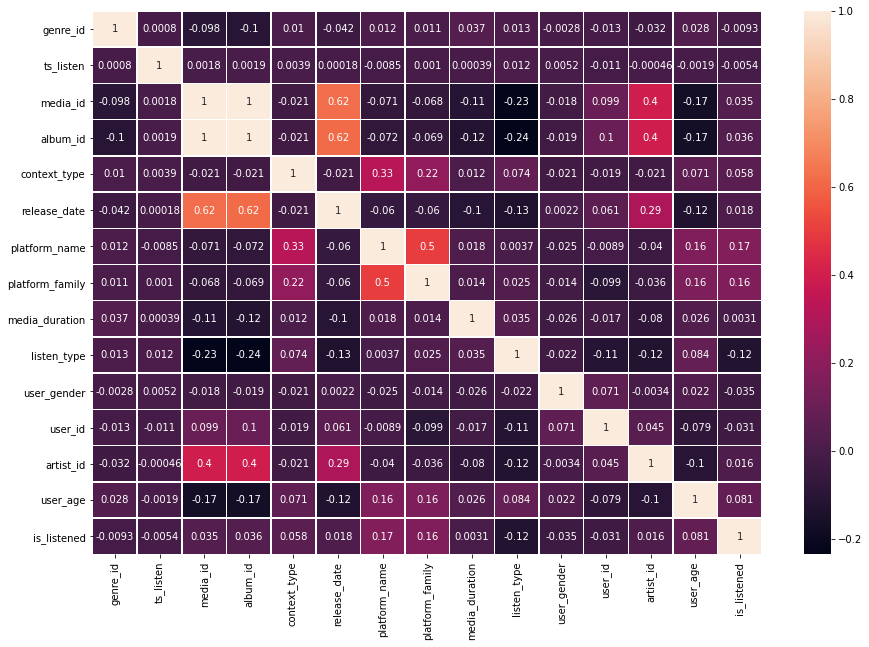

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt

corrMatrix = df_song_train.corr()
fig, ax = plt.subplots(figsize=(15,10))
sn.heatmap(corrMatrix, annot=True, linewidths=.5, ax=ax)

### Feature comparison Test vs Train Dataset
We have to consider that we only can use features to train the model which are also available in the train dataset. The reason for that, is that the model will be applied to the test dataset. If the model is trained to rely heavily for example on feature "F1", but the feature does not occure in the test dataset, we cannot use this feature for training.

First step is to check, wheter we do have the same columns in both datasets:

In [ ]:
#differences from test to train:
print(df_song_test.columns.difference(df_song_train.columns))

#differences from train to test:
print(df_song_train.columns.difference(df_song_test.columns))

Index(['sample_id'], dtype='object')
Index(['is_listened'], dtype='object')


The column **is_listened** is not available in the test dataset. This is expected, as this variable is the label. The column **sample_id** seems to be just an index variable and is not available in the train dataset. Therefore the model will of course not rely on this variable.


Next we analyse wheter the categories of features available in the test data are the same as in the train dataset. We figured out, that this is not the case for two features: **context_type** and **listen_type**

We encountered this by listing the distinct count for all the feature and for each feature we had a look into the distinct values:

**Feature Distinct Count for Test**

In [ ]:
df_unique_test = df_song_test.nunique().reset_index()
df_unique_test.columns = ["Feature", "DistinctCount"]
df_unique_test

,Feature,DistinctCount
0,sample_id,19918
1,genre_id,455
2,ts_listen,19760
3,media_id,9732
4,album_id,7015
5,context_type,4
6,release_date,2717
7,platform_name,3
8,platform_family,3
9,media_duration,462


In [ ]:
df_song_test.context_type.unique()

array([ 1,  5, 20, 23])

Only 1, 5, 20, 23 occure in the test dataset. Therefore, we only train the model with samples which are assigned to these categories.

**Feature Distinct Count for Train**

In [ ]:
df_unique_train = df_song_test.nunique().reset_index()
df_unique_train.columns = ["Feature", "DistinctCount"]
df_unique_train

,Feature,DistinctCount
0,sample_id,19918
1,genre_id,455
2,ts_listen,19760
3,media_id,9732
4,album_id,7015
5,context_type,4
6,release_date,2717
7,platform_name,3
8,platform_family,3
9,media_duration,462


In [ ]:
df_song_train.context_type.unique()

Way more categories occure in the train data set than just 1, 5, 20, 23.

### Class Balances


In [ ]:
notListened = len(df_song_train[df_song_train["is_listened"]==0])

listened = len(df_song_train[df_song_train["is_listened"]==1])

print("listened: {0}%, not listened: {1}%".format(100 * listened /(notListened+listened), 100 * notListened / (notListened+listened)))

listened: 68.4033013557382%, not listened: 31.5966986442618%


# Data Preparation

In [ ]:
df_formatted = df_song_train[df_song_train["ts_listen"]>=315965855].copy() # drop invalid timestamps
df_formatted["ts_listen"] = pd.to_datetime(df_formatted["ts_listen"], 
                                           unit="s")

df_formatted["release_date"] = df_formatted["release_date"].astype(str)
df_formatted["release_date"].head()
df_formatted["release_date"] = pd.to_datetime(df_formatted["release_date"], 
                                              format='%Y%m%d',
                                              errors="coerce")
cats = ["genre_id", 
        "media_id", 
        "album_id", 
        "context_type", 
        "platform_name", 
        "platform_family", 
        "listen_type", 
        "user_gender",
        "user_id", 
        "artist_id", 
        "is_listened"]

for cat in cats:
  df_formatted[cat] = pd.to_numeric(df_formatted[cat])


print("len before filtering context_type", len(df_formatted))
df_formatted = df_formatted[df_formatted["context_type"].isin([1, 5, 20, 23])]
print("len after filtering context_type", len(df_formatted))
df_formatted = df_formatted[df_formatted["listen_type"] == 1]
print("len after filtering listen_type = 1", len(df_formatted))


cols = ["user_id", "media_id"]
#df_formatted = df.df_formatted(frac=0.1)
df_formatted["ts_listen_diff1"] = df_formatted.groupby(cols)["ts_listen"].diff(1)
print(df_formatted)




len before filtering context_type 7558585
len after filtering context_type 1815730
len after filtering listen_type = 1 1815679
         genre_id           ts_listen  ...  is_listened  ts_listen_diff1
2              16 2016-11-19 13:59:13  ...            1              NaT
7               7 2016-11-05 13:48:29  ...            1              NaT
9               7 2016-11-15 12:51:44  ...            1              NaT
12              7 2016-11-05 14:36:43  ...            1              NaT
13              7 2016-11-24 06:18:46  ...            0              NaT
...           ...                 ...  ...          ...              ...
7558825         0 2016-11-29 20:53:54  ...            1              NaT
7558826         0 2016-11-29 16:56:07  ...            1  6 days 10:42:26
7558827         0 2016-11-29 08:10:23  ...            1              NaT
7558828         0 2016-11-29 15:45:30  ...            0              NaT
7558829         0 2016-11-29 05:41:37  ...            0              N

# Model Building

## Boosting using XGBoost

In [ ]:
import xgboost as xgb
from sklearn.datasets import load_iris
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

df_song_train2 = df_formatted

print(len(df_song_train2))
df_song_train2= df_formatted.head(18156)

print(df_song_train2.dtypes)

df_song_train2["ts_listen_diff1"] = df_song_train2["ts_listen_diff1"] / np.timedelta64(1, 's')

print(df_song_train2["ts_listen_diff2"])
if "ts_listen" in df_song_train2.columns or "release_date" in df_song_train2.columns:
  df_song_train2.drop(df_song_train2[["ts_listen", "release_date"]], axis=1, inplace=True)


df_song_shuffled = shuffle(df_song_train2)
x, y = df_song_shuffled.iloc[:,:-1], df_song_shuffled.iloc[:,-1]

data_dmatrix = xgb.DMatrix(data=x, label=y)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
print("train: {0}".format(len(x_train)))
print("test: {0}".format(len(x_test)))

notListened = len(df_song_train[df_song_train["is_listened"]==0])
listened = len(df_song_train[df_song_train["is_listened"]==1])
print("listened: {0}%, not listened: {1}%".format(100 * listened /(notListened+listened), 100 * notListened / (notListened+listened)))

1815679
genre_id                     int64
ts_listen           datetime64[ns]
media_id                     int64
album_id                     int64
context_type                 int64
release_date        datetime64[ns]
platform_name                int64
platform_family              int64
media_duration               int64
listen_type                  int64
user_gender                  int64
user_id                      int64
artist_id                    int64
user_age                     int64
is_listened                  int64
ts_listen_diff1    timedelta64[ns]
dtype: object
Index(['ts_listen_diff1', 'is_listened'], dtype='object')
2       NaN
7       NaN
9       NaN
12      NaN
13      NaN
         ..
68192   NaN
68199   NaN
68200   NaN
68203   NaN
68207   NaN
Name: ts_listen_diff1, Length: 18156, dtype: float64
train: 14524
test: 3632
listened: 68.4033013557382%, not listened: 31.5966986442618%


In [ ]:
model = xgb.XGBClassifier(
    base_score=0.5,
    booster='gbtree',
    colsample_bylevel=1,
    colsample_bynode=1,
    colsample_bytree=1,
    gamma=0,
    learning_rate=0.1,
    max_delta_step=0,
    max_depth=3,
    min_child_weight=1,
    missing=None,
    n_estimators=100, # number of trees which is built (like epochs -> after each tree, the error is minimized)
    n_jobs=1,
    nthread=None,
    objective='binary:logistic',
    random_state=0,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    seed=None,
    silent=None,
    subsample=1,
    verbosity=1)

eval_set = [(x_train, y_train), (x_test, y_test)]

#calc sample weights
train_user_id_count = df_song_train2.groupby("user_id", as_index=False).agg({"user_id": "count"})
#train_user_id_count.hist(bins=30)
anyRedundantUser = (len(train_user_id_count[train_user_id_count["user_id"] > 1]) > 1)
print("any user observed multiple times: {0}".format(anyRedundantUser))

def calc_weights(user_id):
  len(df_song_train2[df_song_train2.user_id == user_id])
  count = len(df_song_train2[df_song_train2.user_id == user_id])
  weight = 1 / count
  return weight


weight_vector = []
n_train_samples = len(x_train)
print("number of train samples: ", len(x_train))
i = 0
if calc_weights == False:
  weights = df_song_train2.apply(lambda row: calc_weights(row['user_id']), axis=1)
  print("weights: ", weights.to_list())

    
model.fit(x_train, y_train, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=False)#, sample_weight=weights)

any user observed multiple times: True
number of train samples:  14524


ValueError: ignored

              precision    recall  f1-score   support

           0       0.58      0.39      0.47      1372
           1       0.69      0.83      0.76      2260

    accuracy                           0.66      3632
   macro avg       0.64      0.61      0.61      3632
weighted avg       0.65      0.66      0.65      3632

accuracy:  0.6643722466960352
training score:  0.6761911319195814


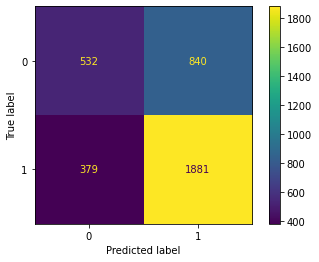

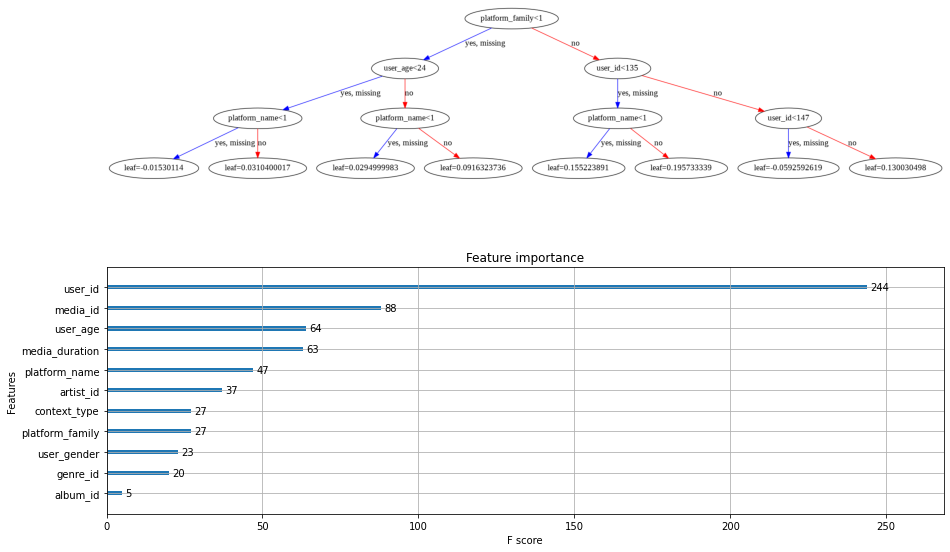

In [ ]:
from xgboost import plot_tree
from sklearn.metrics import roc_curve, auc, roc_auc_score, recall_score, precision_score
import seaborn as sns
import matplotlib.pyplot as plt     
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix
from sklearn.metrics import precision_score,recall_score,accuracy_score,f1_score,roc_auc_score

pred = model.predict(x_test)
cm = confusion_matrix(y_test, pred) #, normalize='all'
plot_confusion_matrix(model, x_test, y_test, values_format='.0f')
cr = classification_report(y_test, pred)
print(cr)

print("accuracy: ", accuracy_score(y_test, pred))
score = model.score(x_train, y_train)
print("training score: ", score)
#cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
#scores = cross_val_score(model, x_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
#print('Mean ROC AUC: %.5f' % mean(scores))
#cv_score = cross_val_score(model, x_train, y_train, cv=10)
#print("crossvalidation mean score: ", cv_score.mean())

roc_auc_score(y_test, pred)

fig, (ax1, ax2) = plt.subplots(2, figsize=(15, 10))
plot_tree(model, ax=ax1)
xgb.plot_importance(model, ax=ax2)

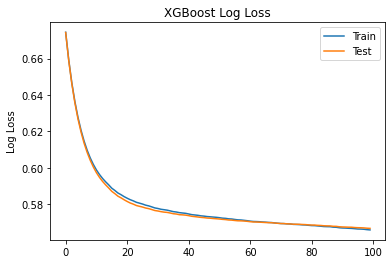

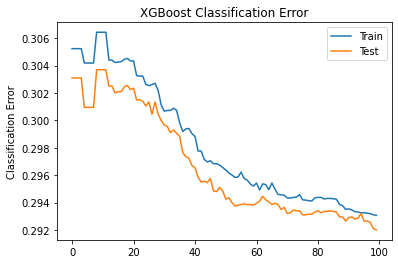

In [ ]:
from matplotlib import pyplot

results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

How should imbalance parameter be set

In [ ]:
# grid search positive class weights with xgboost for imbalance classification
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from xgboost import XGBClassifier
# generate dataset
# define model
model = XGBClassifier()
# define grid
weights = [1, 10, 25, 50, 75, 99, 100, 1000]
param_grid = dict(scale_pos_weight=weights)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')
# execute the grid search
grid_result = grid.fit(x_train, y_train)
# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

KeyboardInterrupt: ignored

### Model Assessment Boosting

## Deep Neural Network

### Mdel Assessment DNN

## Logistic Regression

Multicollinearitity -> Remove Variables which correlate strongly

### Model Assessment LR

In [ ]:
!wget -nc https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
from colab_pdf import colab_pdf
colab_pdf('RecSys.ipynb')

File ‘colab_pdf.py’ already there; not retrieving.





Extracting templates from packages: 100%
[NbConvertApp] Converting notebook /content/drive/My Drive/Colab Notebooks/RecSys.ipynb to pdf
[NbConvertApp] Support files will be in RecSys_files/
[NbConvertApp] Making directory ./RecSys_files
[NbConvertApp] Making directory ./RecSys_files
[NbConvertApp] Making directory ./RecSys_files
[NbConvertApp] Writing 37078 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: [u'xelatex', u'./notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: [u'bibtex', u'./notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 158199 bytes to /content/drive/My Drive/RecSys.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'File ready to be Downloaded and Saved to Drive'